# Data Cleaning, Harmonization, and Exploratory Data Analysis

## Setup

### Import libraries

In [59]:
# standard library
from concurrent import futures
import logging
import multiprocessing as mp
from pathlib import Path
from typing import Callable, Optional, Sequence, Tuple

# third-party libraries
import colorcet as cc
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import SaltRemover
from scipy import stats
from tqdm.auto import tqdm

In [28]:
# setup tqdm
tqdm.pandas()

In [29]:
# setup logging
level = logging.DEBUG
logger = logging.getLogger(__name__)
if logger.hasHandlers():
    logger.handlers.clear()

formatter = logging.Formatter(
    "%(asctime)s - %(name)s - %(levelname)s - %(message)s"
)
ch = logging.StreamHandler()
ch.setFormatter(formatter)
logger.addHandler(ch)
logger.setLevel(level)

logger.info("Imports successful.")


2025-10-26 16:18:05,646 - __main__ - INFO - Imports successful.


### Local libraries

In [49]:
# Defensive canonicalization helper and robust parallel runner
from typing import Iterable, List, Optional

def canonicalize_smiles(smiles: str, isomeric: bool = True) -> Optional[str]:
    """Convert SMILES string to its canonical form with defensive checks.

    Returns None for invalid inputs or on failures.
    """
    # handle missing/NaN inputs
    if smiles is None:
        return None
    try:
        s = str(smiles)
    except Exception:
        logger.warning(f"Unable to convert SMILES to string: {smiles}")
        return None

    # parse molecule
    mol = Chem.MolFromSmiles(s)
    if mol is None:
        logger.debug(f"Invalid SMILES string could not be parsed: {s}")
        return None

    # remove salts safely
    try:
        remover = SaltRemover.SaltRemover()
        mol = remover.StripMol(mol, dontRemoveEverything=True)
    except Exception:
        logger.exception(f"Salt removal failed for SMILES: {s}")
        return None

    if mol.GetNumAtoms() == 0:
        logger.debug(f"Molecule empty after salt removal: {s}")
        return None

    # return canonical SMILES (catch failures)
    try:
        smi = Chem.MolToSmiles(mol, canonical=True, isomericSmiles=isomeric, doRandom=False)
        return smi
    except Exception:
        logger.exception(f"MolToSmiles failed for molecule from SMILES: {s}")
        return None

def parallel_canonicalize_smiles(smiles_list: Iterable, isomeric: bool = True, max_workers: int = None) -> List[Optional[str]]:
    """
    Parallel canonicalization that submits all tasks first and then retrieves results.

    - Submits all jobs with executor.submit() to ensure all computations are started.
    - Uses futures.as_completed to retrieve results as they finish, but stores each
      result at its original index so output order matches input order.
    - Handles per-task exceptions and logs them, returning None for failed items.
    """
    if smiles_list is None:
        return []

    # coerce to list to allow indexing and deterministic ordering
    smiles_seq = list(smiles_list)
    n = len(smiles_seq)
    if n == 0:
        return []

    if max_workers is None:
        max_workers = min(32, (mp.cpu_count() or 1) + 4)

    logger.debug(f"Using {max_workers} workers for parallel SMILES canonicalization. Total tasks: {n}")

    results: List[Optional[str]] = [None] * n
    future_to_index = {}
    with futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        # submit all tasks first
        for idx, smi in enumerate(smiles_seq):
            future = executor.submit(canonicalize_smiles, smi, isomeric)
            future_to_index[future] = idx

        # collect results as they complete, but place them at the original index
        for completed in tqdm(futures.as_completed(future_to_index), total=n, desc="Canonicalizing SMILES"):
            idx = future_to_index[completed]
            try:
                res = completed.result()
            except Exception:
                logger.exception(f"Canonicalization task failed for index {idx} (SMILES: {smiles_seq[idx]})")
                res = None
            results[idx] = res

    return results


In [82]:
def calc_stats(series: Series) -> str:
    """
    Calculate summary statistics for a pandas Series and format as a string.

    Parameters
    ----------
    series : pandas.Series
        Numeric column to summarize.

    Returns
    -------
    str
        Formatted string with min, max, mean, median, std, skew, kurtosis, and count.
    """
    array = series.dropna().to_numpy()

    # calc min, max, median, mean, std, skew, kurtosis, count
    out = {
        "min": np.min(array),
        "max": np.max(array),
        "mean": np.mean(array),
        "median": np.median(array),
        "std": np.std(array, ddof=1) if len(array) > 1 else np.nan,
        "skew": stats.skew(array) if len(array) > 2 else np.nan,
        "kurtosis": stats.kurtosis(array) if len(array) > 3 else np.nan,
        "count": len(array),
    }
    stats_str = (
        f"min: {out['min']:.4g}\n"
        f"max: {out['max']:.4g}\n"
        f"mean: {out['mean']:.4g}\n"
        f"median: {out['median']:.4g}\n"
        f"std: {out['std']:.4g}\n"
        f"skew: {out['skew']:.4g}\n"
        f"kurtosis: {out['kurtosis']:.4g}\n"
        f"count: {out['count']}"
    )
    return stats_str

def plot_numeric_distributions(
    df: DataFrame,
    columns: Optional[Sequence[str]] = None,
    n_cols: int = 3,
    figsize_per_cell: Tuple[int, int] = (6, 4),
    stat_func: Callable[[Series], str] = calc_stats,
    kde: bool = True,
    title: Optional[str] = None,
    save_path: Optional[Path] = None,
) -> Tuple[plt.Figure, np.ndarray]:
    """
    Plot histograms (with optional KDE) for numeric columns in a dataframe
    arranged in a grid, adding summary statistics text on each subplot.

    Parameters
    ----------
    df : pandas.DataFrame
        Input dataframe.
    columns : Sequence[str], optional
        Sequence of column names to plot. If None, all numeric columns are used.
    n_cols : int
        Number of columns in the grid.
    figsize_per_cell : tuple (width, height)
        Size multiplier for each grid cell.
    stat_func : callable
        Function that accepts a pandas.Series and returns a formatted string
        with statistics (used to render the textbox). Default: calc_stats.
    kde : bool
        Whether to draw KDE on top of histograms.
    title : str, optional
        Optional overall title for the figure.
    save_path : pathlib.Path, optional
        If provided, saves the figure to this path.

    Returns
    -------
    fig : matplotlib.figure.Figure
        The created figure.
    axes : numpy.ndarray
        Flattened array of Axes objects (unused axes will be turned off).
    """
    if columns is None:
        columns = df.select_dtypes(include=["number"]).columns.tolist()

    n_features = len(columns)
    if n_features == 0:
        raise ValueError("No numeric columns to plot.")

    n_rows = int(np.ceil(n_features / float(n_cols)))
    fig_w = figsize_per_cell[0] * n_cols
    fig_h = figsize_per_cell[1] * n_rows

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(fig_w, fig_h))
    axes = np.atleast_1d(np.array(axes).flatten())

    for i, col in enumerate(columns):
        ax = axes[i]
        series = df[col].dropna()
        sns.histplot(series, kde=kde, ax=ax)
        try:
            stat_text = stat_func(series)
        except Exception:
            stat_text = ""
        ax.set_xlabel(col, fontsize=12)
        ax.set_ylabel("Count", fontsize=12)
        ax.grid(True, linestyle=":", alpha=0.7)
        ax.tick_params(axis="x", labelrotation=30, labelsize=10)
        ax.tick_params(axis="y", labelsize=10)
        if stat_text:
            ax.text(
                0.95,
                0.95,
                stat_text,
                transform=ax.transAxes,
                fontsize=10,
                verticalalignment="top",
                horizontalalignment="right",
                bbox=dict(facecolor="white", alpha=0.75, edgecolor="black"),
            )

    # turn off any unused axes
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    if title:
        fig.suptitle(title, fontsize=16, y=1.01)

    fig.tight_layout()
    if save_path is not None:
        fig.savefig(str(save_path), bbox_inches="tight", dpi=150)

    return fig, axes


def plot_correlation_matrix(
    df: DataFrame,
    columns: Optional[Sequence[str]] = None,
    figsize: Tuple[int, int] = (12, 10),
    cmap: str = "mako",
    annot: bool = True,
    fmt: str = ".2f",
    square: bool = True,
    cbar_label: str = "Correlation",
    linewidths: float = 0.5,
    linecolor: str = "white",
    annot_kws: Optional[dict] = None,
    xtick_rotation: int = 45,
    xtick_ha: str = "right",
    xtick_fontsize: int = 12,
    ytick_rotation: int = 0,
    ytick_fontsize: int = 12,
    title: Optional[str] = "Correlation Matrix of Numeric Columns",
    save_path: Optional[Path] = None,
) -> Tuple[plt.Figure, plt.Axes]:
    """
    Compute and plot a correlation matrix for numeric columns in `df`.

    Returns the (fig, ax).
    """
    if columns is None:
        columns = df.select_dtypes(include=["number"]).columns.tolist()
    if len(columns) == 0:
        raise ValueError("No numeric columns to compute correlation for.")

    corr = df[columns].corr()

    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(
        corr,
        annot=annot,
        cmap=cmap,
        fmt=fmt,
        ax=ax,
        square=square,
        cbar_kws={"label": cbar_label},
        linewidths=linewidths,
        linecolor=linecolor,
        annot_kws=(annot_kws or {"size": 12}),
    )

    if title:
        ax.set_title(title, fontsize=18)
    ax.set_xlabel("Features", fontsize=14)
    ax.set_ylabel("Features", fontsize=14)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=xtick_rotation, ha=xtick_ha, fontsize=xtick_fontsize)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=ytick_rotation, fontsize=ytick_fontsize)
    fig.tight_layout()

    if save_path is not None:
        fig.savefig(str(save_path), bbox_inches="tight", dpi=150)

    return fig, ax

In [72]:
cols_with_units = {
    "LogD": "(None)",
    "KSOL": "(uM)",
    "HLM CLint": "(mL/min/kg)",
    "MLM CLint": "(mL/min/kg)",
    "Caco-2 Permeability Papp A>B": "(10^-6 cm/s)",
    "Caco-2 Permeability Efflux": "(None)",
    "MPPB": "(% unbound)",
    "MBPB": "(% unbound)",
    "MGMB": "(% unbound)",
}

transformations = {
    "None": lambda x: x,
    "10^(x+6)": lambda x: 10.0 ** (x + 6.0),
    "10^(x)": lambda x: 10.0 ** (x),
}

## Load Data

In [73]:
cleaned_data = {}

In [74]:
# project data root directory
base_data_dir = Path().cwd().parents[0] / "assets/dataset/raw"

if not base_data_dir.exists():
    raise FileNotFoundError(f"Data directory not found at {base_data_dir}")

logger.info(f"Data directory found at {base_data_dir}")
for dataset_dir in base_data_dir.iterdir():
    logger.info(f"Dataset name: {dataset_dir.name}")

2025-10-26 16:27:19,932 - __main__ - INFO - Data directory found at /media/aglisman/Linux_Overflow/home/aglisman/VSCodeProjects/OpenADMET-ExpansionRx-Blind-Challenge/assets/dataset/raw
2025-10-26 16:27:19,933 - __main__ - INFO - Dataset name: NCATS
2025-10-26 16:27:19,933 - __main__ - INFO - Dataset name: admetica
2025-10-26 16:27:19,933 - __main__ - INFO - Dataset name: Polaris-Antiviral
2025-10-26 16:27:19,933 - __main__ - INFO - Dataset name: TDC
2025-10-26 16:27:19,933 - __main__ - INFO - Dataset name: Polaris-Biogen
2025-10-26 16:27:19,934 - __main__ - INFO - Dataset name: ExpansionRX
2025-10-26 16:27:19,934 - __main__ - INFO - Dataset name: KERMT
2025-10-26 16:27:19,934 - __main__ - INFO - Dataset name: PharmaBench
2025-10-26 16:27:19,934 - __main__ - INFO - Dataset name: ChEMBL


### Challenge Data: ExpansionRX

In [78]:
# load data
data_path = base_data_dir / "ExpansionRX/expansion_teaser.csv"
df_expansionrx_teaser = pd.read_csv(data_path)

# rename cols to have units
df_expansionrx_teaser.rename(
    columns={k: f"{k} {v}" for k, v in cols_with_units.items()},
    inplace=True,
)

# drop rows with invalid SMILES
df_expansionrx_teaser["SMILES"] = parallel_canonicalize_smiles(
    df_expansionrx_teaser["SMILES"].tolist(),
    isomeric=True,
)
n_none_smiles = df_expansionrx_teaser["SMILES"].isnull().sum()
if n_none_smiles > 0:
    logger.warning(f"Dropping {n_none_smiles} rows with invalid SMILES")
    df_expansionrx_teaser.dropna(subset=["SMILES"], inplace=True)
    df_expansionrx_teaser.reset_index(drop=True, inplace=True)

logger.info(f"Dataframe shape: {df_expansionrx_teaser.shape}")
logger.info(f"Dataframe columns: {df_expansionrx_teaser.columns.tolist()}")

2025-10-26 16:28:06,004 - __main__ - DEBUG - Using 28 workers for parallel SMILES canonicalization. Total tasks: 532


Canonicalizing SMILES:   0%|          | 0/532 [00:00<?, ?it/s]

2025-10-26 16:28:06,296 - __main__ - INFO - Dataframe shape: (532, 11)
2025-10-26 16:28:06,296 - __main__ - INFO - Dataframe columns: ['Molecule Name', 'SMILES', 'LogD (None)', 'KSOL (uM)', 'HLM CLint (mL/min/kg)', 'MLM CLint (mL/min/kg)', 'Caco-2 Permeability Papp A>B (10^-6 cm/s)', 'Caco-2 Permeability Efflux (None)', 'MPPB (% unbound)', 'MBPB (% unbound)', 'MGMB (% unbound)']


In [79]:
cleaned_data["expansionrx_teaser"] = df_expansionrx_teaser.copy()

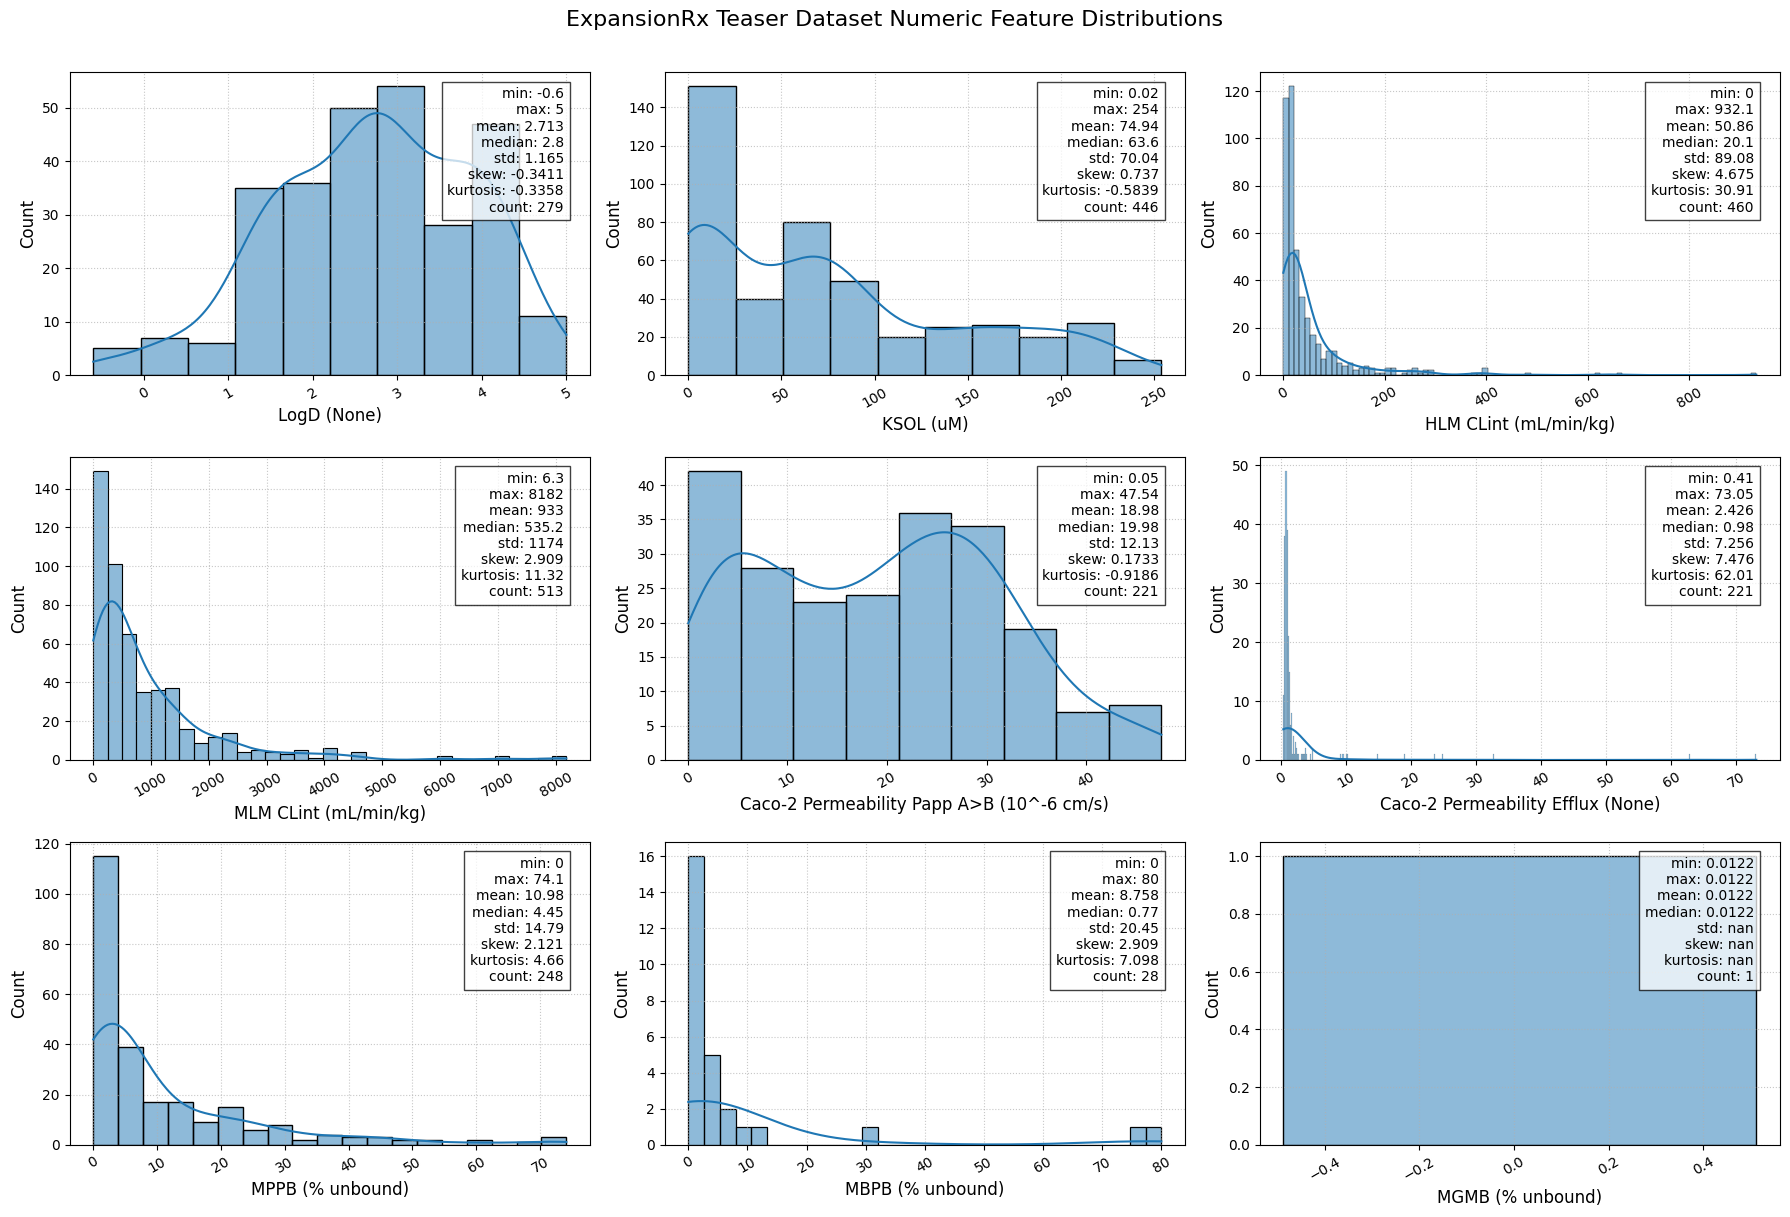

In [81]:
fig, ax = plot_numeric_distributions(
    df_expansionrx_teaser,
    n_cols=3,
    title="ExpansionRx Teaser Dataset Numeric Feature Distributions",
    save_path=data_path.parent / "expansionrx_teaser_numeric_distributions.png",
)


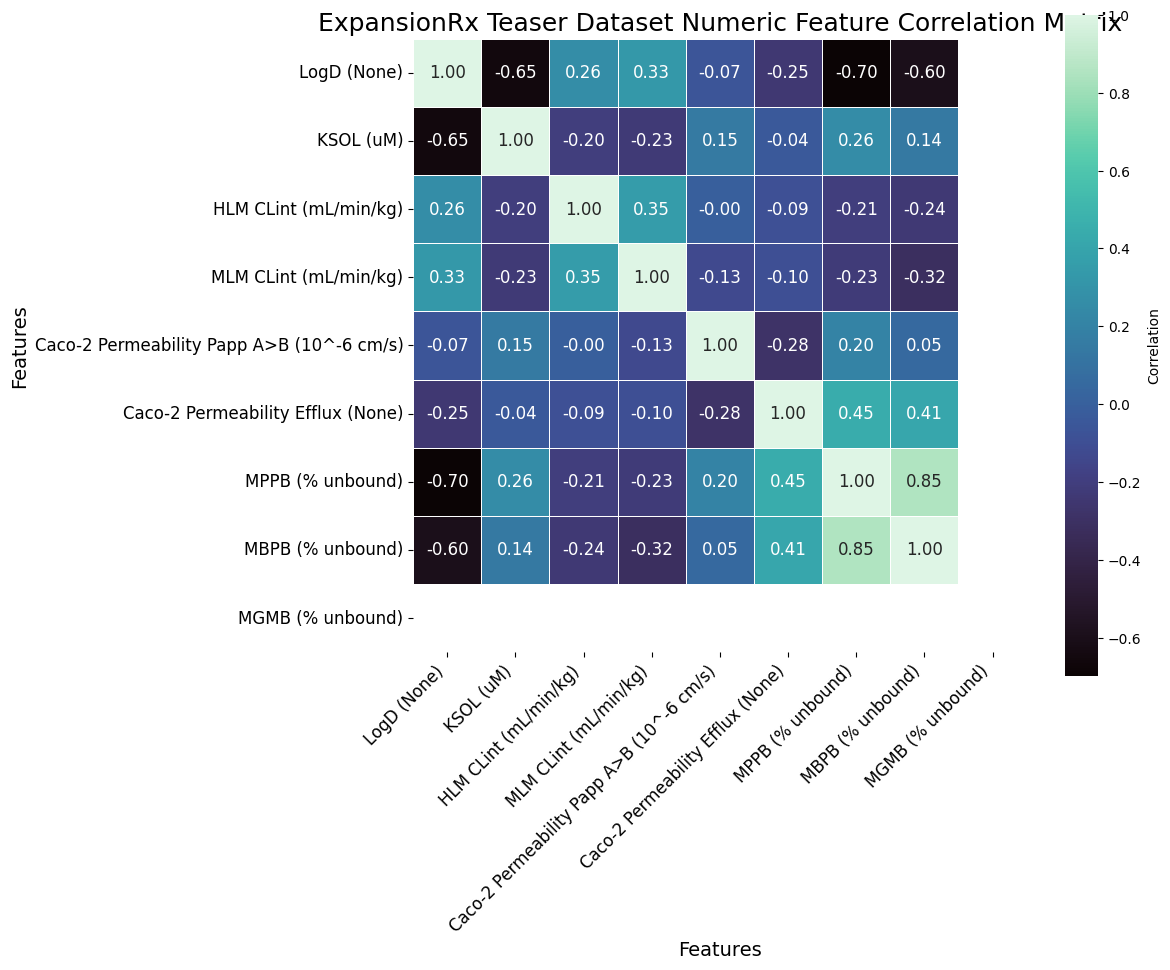

In [83]:
fig, ax = plot_correlation_matrix(
    df_expansionrx_teaser,
    title="ExpansionRx Teaser Dataset Numeric Feature Correlation Matrix",
    save_path=data_path.parent / "expansionrx_teaser_numeric_correlation_matrix.png",
)

### KERMT Dataset

#### Public

In [84]:
files_biogen = [
    "KERMT/export_public_cluster_split/all_test_cluster_morgan.csv",
    "KERMT/export_public_cluster_split/all_train_fold_0_cluster_morgan.csv",
    "KERMT/export_public_cluster_split/all_val_fold_0_cluster_morgan.csv",
]

df_kermt_public = pd.DataFrame()
for f in files_biogen:
    df = pd.read_csv(base_data_dir / f)
    df["file"] = f
    df_kermt_public = pd.concat([df_kermt_public, df], ignore_index=True)

# rename smiles --> SMILES
df_kermt_public.rename(columns={"smiles": "SMILES"}, inplace=True)

# drop rows with invalid SMILES
df_kermt_public["SMILES"] = parallel_canonicalize_smiles(
    df_kermt_public["SMILES"].tolist(),
    isomeric=True,
)
n_none_smiles = df_kermt_public["SMILES"].isnull().sum()
if n_none_smiles > 0:
    logger.warning(f"Dropping {n_none_smiles} rows with invalid SMILES")
    df_kermt_public.dropna(subset=["SMILES"], inplace=True)
    df_kermt_public.reset_index(drop=True, inplace=True)

logger.info(f"KERMT Public Dataframe shape: {df_kermt_public.shape}")
logger.info(f"KERMT Public Dataframe columns: {df_kermt_public.columns.tolist()}")

# print finite number of entries for each column
for col in df_kermt_public.columns:
    if not pd.api.types.is_numeric_dtype(df_kermt_public[col]):
        continue
    n_finite = np.isfinite(df_kermt_public[col]).sum()
    logger.info(f"Column '{col}' has {n_finite} finite entries out of {len(df_kermt_public)}")

2025-10-26 16:30:14,542 - __main__ - DEBUG - Using 28 workers for parallel SMILES canonicalization. Total tasks: 114112


Canonicalizing SMILES:   0%|          | 0/114112 [00:00<?, ?it/s]

2025-10-26 16:31:14,799 - __main__ - INFO - KERMT Public Dataframe shape: (114112, 27)
2025-10-26 16:31:14,799 - __main__ - INFO - KERMT Public Dataframe columns: ['SMILES', 'CL_microsome_human', 'CL_microsome_mouse', 'CL_microsome_rat', 'CL_total_dog', 'CL_total_human', 'CL_total_monkey', 'CL_total_rat', 'CYP2C8_inhibition', 'CYP2C9_inhibition', 'CYP2D6_inhibition', 'CYP3A4_inhibition', 'Dog_fraction_unbound_plasma', 'Human_fraction_unbound_plasma', 'Monkey_fraction_unbound_plasma', 'Rat_fraction_unbound_plasma', 'Papp_Caco2', 'Pgp_human', 'hERG_binding', 'LogD_pH_7.4', 'kinetic_logSaq', 'thermo_logSaq', 'VDss_dog', 'VDss_human', 'VDss_monkey', 'VDss_rat', 'file']
2025-10-26 16:31:14,800 - __main__ - INFO - Column 'CL_microsome_human' has 5218 finite entries out of 114112
2025-10-26 16:31:14,800 - __main__ - INFO - Column 'CL_microsome_mouse' has 663 finite entries out of 114112
2025-10-26 16:31:14,801 - __main__ - INFO - Column 'CL_microsome_rat' has 1798 finite entries out of 114112

In [85]:
# map from KERMT data to ExpansionRX data on SMILES
map_cols_kermt_to_expansionrx = [
    {
        "input_col": "LogD_pH_7.4",
        "output_col": "LogD (None)",
        "transform": transformations["None"],
    },
    {
        "input_col": "kinetic_logSaq",  # log(M)
        "output_col": "KSOL (uM)",
        "transform": transformations["10^(x+6)"],
    },
    {
        "input_col": "CL_microsome_human",  # log(mL/min/mg)
        "output_col": "HLM CLint (mL/min/kg)",
        "transform": transformations["10^(x)"],
    },
    {
        "input_col": "CL_microsome_mouse",  # log(mL/min/mg)
        "output_col": "MLM CLint (mL/min/kg)",
        "transform": transformations["10^(x)"],
    },
    {
        "input_col": "Papp_Caco2",  # log(10^-6 cm/sec)
        "output_col": "Caco-2 Permeability Papp A>B (10^-6 cm/s)",
        "transform": transformations["10^(x)"],
    },
    {
        # REVIEW: low confidence mapping
        "input_col": "Pgp_human",  # log(None)
        "output_col": "Caco-2 Permeability Efflux (None)",
        "transform": transformations["10^(x)"],
    },
]

df_kermt_public_admet_cleaned = df_kermt_public[["SMILES"]]
for mapping in map_cols_kermt_to_expansionrx:
    input_col = mapping["input_col"]
    output_col = mapping["output_col"]
    transform = mapping["transform"]

    df_input = df_kermt_public[["SMILES", input_col]].copy()
    df_input[output_col] = df_input[input_col].apply(transform).copy()
    df_input.drop(columns=[input_col], inplace=True)

    df_kermt_public_admet_cleaned = pd.merge(df_kermt_public_admet_cleaned, df_input, on="SMILES")

In [91]:
# limit KSol to < 250
idx_infinite_ksol = df_kermt_public_admet_cleaned["KSOL (uM)"].isnull()
idx_too_large = df_kermt_public_admet_cleaned["KSOL (uM)"] > 250.0
idx_remove = ~idx_infinite_ksol & idx_too_large
df_kermt_public_admet_cleaned = df_kermt_public_admet_cleaned[~idx_remove].reset_index(drop=True)

# limit Caco-2 Permeability Papp A>B to < 100
idx_infinite_caco2 = df_kermt_public_admet_cleaned["Caco-2 Permeability Papp A>B (10^-6 cm/s)"].isnull()
idx_too_large_caco2 = df_kermt_public_admet_cleaned["Caco-2 Permeability Papp A>B (10^-6 cm/s)"] > 100.0
idx_remove_caco2 = ~idx_infinite_caco2 & idx_too_large_caco2
df_kermt_public_admet_cleaned = df_kermt_public_admet_cleaned[~idx_remove_caco2].reset_index(drop=True)

# limit Caco-2 Permeability Efflux to < 100
idx_infinite_efflux = df_kermt_public_admet_cleaned["Caco-2 Permeability Efflux (None)"].isnull()
idx_too_large_efflux = df_kermt_public_admet_cleaned["Caco-2 Permeability Efflux (None)"] > 100.0
idx_remove_efflux = ~idx_infinite_efflux & idx_too_large_efflux
df_kermt_public_admet_cleaned = df_kermt_public_admet_cleaned[~idx_remove_efflux].reset_index(drop=True)

# drop rows with all NaN values across ADMET columns
admet_cols = [mapping["output_col"] for mapping in map_cols_kermt_to_expansionrx]
df_kermt_public_admet_cleaned.dropna(subset=admet_cols, how="all", inplace=True)
df_kermt_public_admet_cleaned.reset_index(drop=True, inplace=True)

logger.info(f"Merged KERMT-ExpansionRX Dataframe shape: {df_kermt_public_admet_cleaned.shape}")
logger.info(f"Merged KERMT-ExpansionRX Dataframe columns: {df_kermt_public_admet_cleaned.columns.tolist()}")

# check for repeated SMILES
n_total = len(df_kermt_public_admet_cleaned)
n_unique = df_kermt_public_admet_cleaned["SMILES"].nunique()
n_duplicates = n_total - n_unique
if n_duplicates > 0:
    logger.warning(f"Found {n_duplicates} duplicate SMILES in merged KERMT-ExpansionRX dataframe")
    # average (skip NaNs) over duplicates
    df_kermt_public_admet_cleaned = df_kermt_public_admet_cleaned.groupby("SMILES", as_index=False).mean()
    logger.info(f"Dataframe shape after averaging duplicates: {df_kermt_public_admet_cleaned.shape}")

# check for overlap with ExpansionRx teaser dataset
smiles_teaser = set(df_expansionrx_teaser["SMILES"].tolist())
smiles_kermt_expansionrx = set(df_kermt_public_admet_cleaned["SMILES"].tolist())
overlap_smiles = smiles_teaser.intersection(smiles_kermt_expansionrx)
n_overlap = len(overlap_smiles)
if n_overlap > 0:
    logger.warning(f"Found {n_overlap} overlapping SMILES between ExpansionRx teaser and KERMT-ExpansionRX datasets")

2025-10-26 16:34:38,327 - __main__ - INFO - Merged KERMT-ExpansionRX Dataframe shape: (91556, 7)
2025-10-26 16:34:38,327 - __main__ - INFO - Merged KERMT-ExpansionRX Dataframe columns: ['SMILES', 'LogD (None)', 'KSOL (uM)', 'HLM CLint (mL/min/kg)', 'MLM CLint (mL/min/kg)', 'Caco-2 Permeability Papp A>B (10^-6 cm/s)', 'Caco-2 Permeability Efflux (None)']
2025-10-26 16:34:38,341 - __main__ - WARNING - Found 2513 duplicate SMILES in merged KERMT-ExpansionRX dataframe
2025-10-26 16:34:38,402 - __main__ - INFO - Dataframe shape after averaging duplicates: (89043, 7)
2025-10-26 16:34:38,407 - __main__ - WARNING - Found 2 overlapping SMILES between ExpansionRx teaser and KERMT-ExpansionRX datasets


In [92]:
cleaned_data["kermt_public"] = df_kermt_public_admet_cleaned.copy()

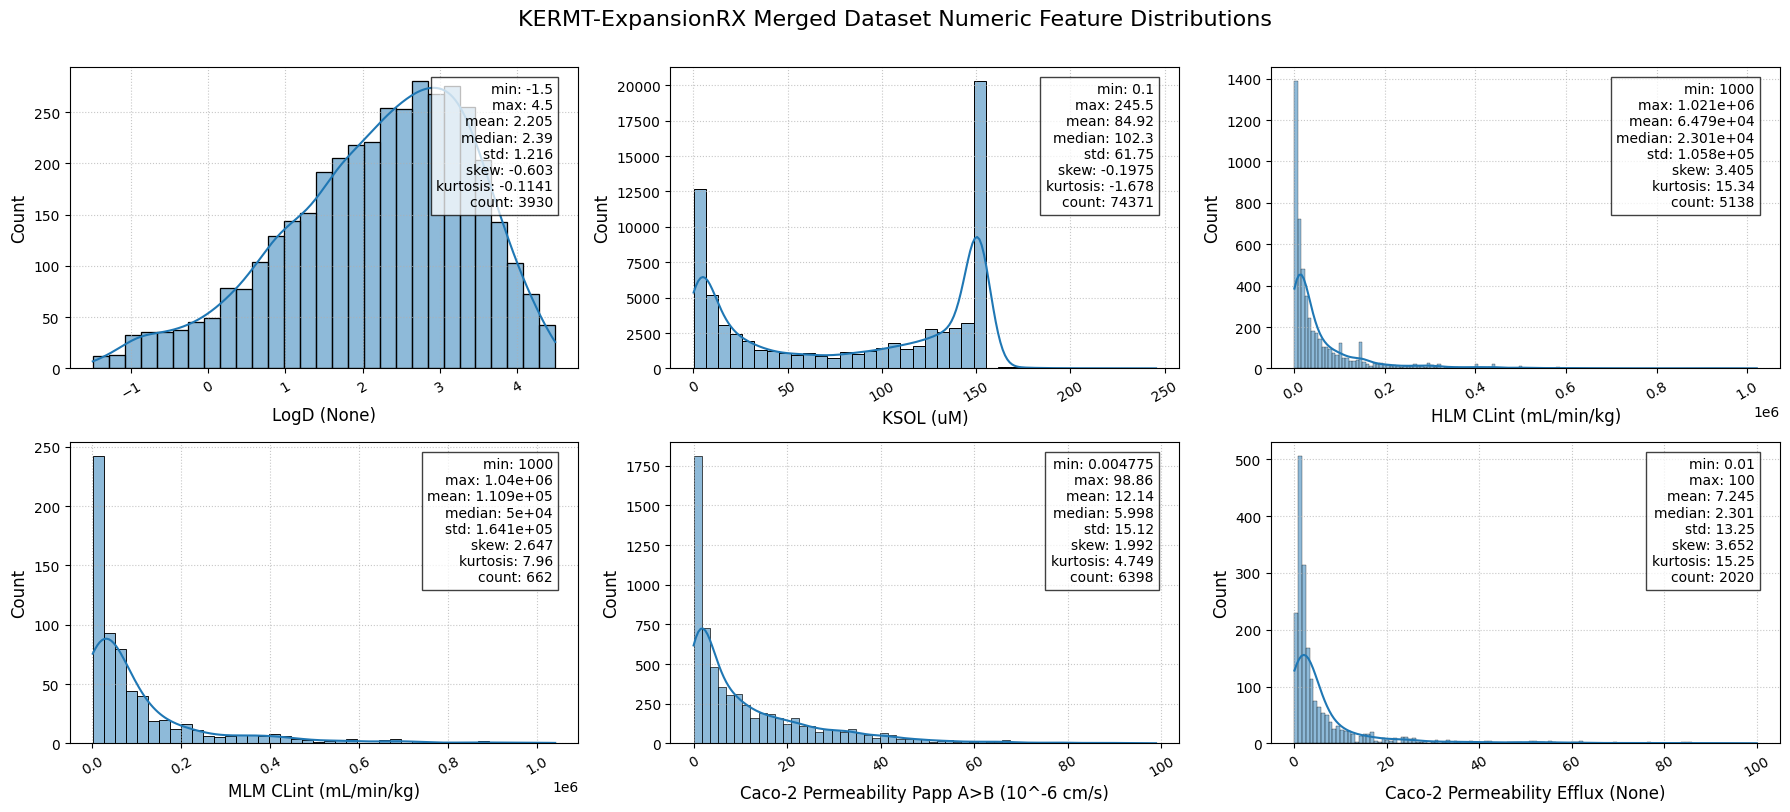

In [93]:
fig, ax = plot_numeric_distributions(
    df_kermt_public_admet_cleaned,
    n_cols=3,
    title="KERMT-ExpansionRX Merged Dataset Numeric Feature Distributions",
    save_path=data_path.parent / "kermt_expansionrx_numeric_distributions.png",
)

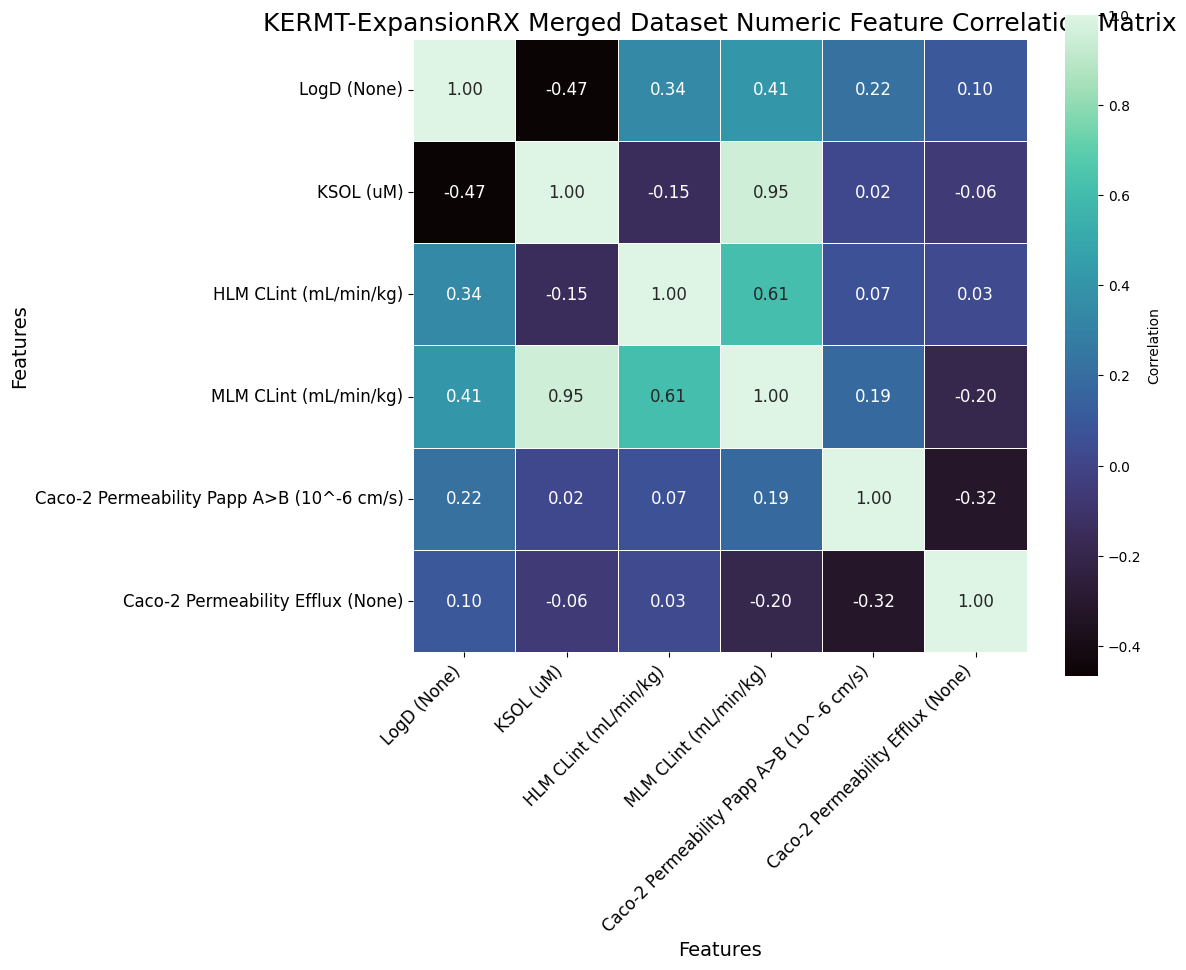

In [95]:
fig, ax = plot_correlation_matrix(
    df_kermt_public_admet_cleaned,
    title="KERMT-ExpansionRX Merged Dataset Numeric Feature Correlation Matrix",
    save_path=data_path.parent / "kermt_expansionrx_numeric_correlation_matrix.png",
) 

#### Biogen

In [ ]:
files_biogen = [
    "KERMT/export_biogen_cluster_split/all_test_cluster_morgan.csv",
    "KERMT/export_biogen_cluster_split/all_train_fold_0_cluster_morgan.csv",
    "KERMT/export_biogen_cluster_split/all_val_fold_0_cluster_morgan.csv",
]

df_kermt_biogen = [pd.read_csv(base_data_dir / file) for file in files_biogen]
df_kermt_biogen = pd.concat(df_kermt_biogen, ignore_index=True)
logger.info(f"KERMT Biogen Dataframe shape: {df_kermt_biogen.shape}")
logger.info(f"KERMT Biogen Dataframe columns: {df_kermt_biogen.columns.tolist()}")

### PharmaBench

### TDC

### NCATS

### Admetica

### ChEMBL

## Final

In [ ]:
# Save all cleaned datasets as a single dataframe with column for dataset name
df_out = pd.DataFrame()
for name, df in cleaned_data.items():
    df_temp = df.copy()
    df_temp["dataset"] = name
    df_out = pd.concat([df_out, df_temp], axis=0)
    
df_out.reset_index(drop=True, inplace=True)
output_path = base_data_dir.parent / "cleaned_combined_datasets.csv"
df_out.to_csv(output_path, index=False)

In [ ]:
# plot the distribution of dataset counts
dataset_counts = df_out["dataset"].value_counts()
fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(
    x=dataset_counts.index,
    y=dataset_counts.values,
    ax=ax,
    palette="viridis",
    hue=dataset_counts.index,
    dodge=False,
)
ax.set_xlabel("Dataset", fontsize=14)
ax.set_ylabel("Count", fontsize=14)
ax.set_title("Distribution of Dataset Counts", fontsize=18)
ax.tick_params(axis="x", labelrotation=30, labelsize=12)
ax.set_yscale("log")
fig.tight_layout()

# save al 